# Amazon Basin Bird Species Richness & Forest Cover Loss (2001–2024)

By Nithyasri Paleti  
Honors Contract – Impact of Amazon Deforestation on Bird Diversity  

---

## Table of Contents

1. Project Overview  
2. Setup & Imports  
3. Global Biodiversity Information Facility (GBIF) Bird Data: Acquisition & Cleaning
5. Annual Bird Species Richness and Observation Effort (Summary Table)
6. Global Forest Watch (GFW) Data: Acquisition & Cleaning  
7. Merging Bird Richness with Forest Loss  
8. Question 1 – Forest Loss vs Bird Diversity  
9. Question 2 – Endemic vs Generalist Species  
10. Question 3 – Time Lag Between Forest Loss and Bird Richness  
11. Question 4 – Threshold Effects in Forest Loss  
12. Question 5 – Sampling Bias in GBIF and Effort Normalization  
13. Question 6 – Regional Differences in Bird Diversity Trends

# Project Overview

**Goals:**

- Clean and filter multi million row GBIF data (birds).
- Aggregate to annual species richness and observation effort.
- Query the GFW Data API for annual forest loss (ha).
- Merge both datasets into a common annual time series.
- Answer the following questions:
  1. Forest cover change & correlation with bird diversity  
  2. Endemic vs generalist responses  
  3. Time lag after forest loss  
  4. Threshold in forest loss  
  5. Sampling bias in GBIF & normalization  
  6. Regional differences in bird diversity trends

# Setup & Imports
Install and import required libraries.

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import requests, json
import os
import time

In [86]:
import sys, platform
print("Python:", sys.version)
import pandas, numpy, sklearn, matplotlib
print("pandas:", pandas.__version__)
print("numpy:", numpy.__version__)
print("sklearn:", sklearn.__version__)
print("matplotlib:", matplotlib.__version__)

Python: 3.13.7 (v3.13.7:bcee1c32211, Aug 14 2025, 19:10:51) [Clang 16.0.0 (clang-1600.0.26.6)]
pandas: 2.3.3
numpy: 2.3.5
sklearn: 1.7.2
matplotlib: 3.10.7


# GBIF Data Acquisition
Loading the GBIF Simple Export (tab-delimited CSV).  
Only essential columns are read using the `usecols` filter.

In [6]:
from pathlib import Path

data_dir = Path("data")
data_dir.mkdir(exist_ok=True)

gbif_path = data_dir / "gbif_birds.csv"
usecols = ["gbifID", "species", "scientificName", "year", "decimalLatitude", "decimalLongitude", "countryCode", "basisOfRecord", "issue"]

df = pd.read_csv(gbif_path, sep="\t",            # GBIF Simple exports are tab-separated
                 usecols=lambda c: c in usecols,  # read only needed columns
                 low_memory = False)   

print(df.shape)
df.head()

(5845064, 9)


,gbifID,species,scientificName,countryCode,decimalLatitude,decimalLongitude,year,basisOfRecord,issue
0,4410448329,Lophostrix cristata,"Lophostrix cristata (Daudin, 1800)",EC,-0.520699,-76.410152,2023,HUMAN_OBSERVATION,NaN
1,2835487099,Cathartes melambrotus,"Cathartes melambrotus Wetmore, 1964",BR,-2.915611,-59.521179,2013,HUMAN_OBSERVATION,NaN
2,2838629294,Paroaria gularis,"Paroaria gularis (Linnaeus, 1766)",EC,0.005735,-76.203554,2013,HUMAN_OBSERVATION,NaN
3,2842691090,Ochthornis littoralis,"Ochthornis littoralis (Pelzeln, 1868)",EC,-1.100007,-76.718102,2010,HUMAN_OBSERVATION,NaN
4,3726248065,Hylophylax punctulatus,"Hylophylax punctulatus (Des Murs, 1856)",CO,3.988200,-67.859345,2015,HUMAN_OBSERVATION,NaN


### Data quality assessment

In [93]:
print(f"Total records loaded: {len(df):}")
print(f"Records with issues flagged: {df['issue'].notna().sum():} ({df['issue'].notna().sum()/len(df)*100:.2f}%)")

if df['issue'].notna().sum() > 0:
    print(f"\nMost common issues:")
    issue_counts = df['issue'].value_counts().head()
    for issue, count in issue_counts.items():
        print(f"  {issue}: {count:,}")

Total records loaded: 1988572
Records with issues flagged: 1956057 (98.36%)

Most common issues:
  COORDINATE_ROUNDED;CONTINENT_DERIVED_FROM_COORDINATES;TAXON_CONCEPT_ID_NOT_FOUND: 998,661
  CONTINENT_DERIVED_FROM_COORDINATES;TAXON_CONCEPT_ID_NOT_FOUND: 864,468
  COORDINATE_ROUNDED;CONTINENT_DERIVED_FROM_COORDINATES;TAXON_ID_NOT_FOUND: 47,573
  CONTINENT_DERIVED_FROM_COORDINATES: 13,045
  COORDINATE_ROUNDED;CONTINENT_DERIVED_FROM_COORDINATES;TAXON_CONCEPT_ID_NOT_FOUND;TAXON_MATCH_FUZZY: 5,853


#### What this means:
The most common were metadata-standardization issues (e.g., coordinate rounding, continent inference, taxonomic backbone mismatches).
These flags do not indicate errors but rather reflect GBIF’s standardized processing.
No issues suggested systematic coordinate errors or taxonomic invalidity, so all records were retained for downstream analyses.

# GBIF Data Cleaning and Filtering
1. Remove rows with missing species, coordinates, or year
2. Convert year to integer   
3. Restrict year 2000–2024  
4. Remove exact duplicates  
5. Apply Amazon Basin bounding box  

In [8]:
# Drop missing fields
df = df.dropna(subset=["species", "year", "decimalLatitude", "decimalLongitude"])

# Convert year
df["year"] = df["year"].astype(int)

# Restrict years
df = df[(df["year"] >= 2000) & (df["year"] <= 2024)]

# Remove duplicates
df = df.drop_duplicates(subset=["species", "year", "decimalLatitude", "decimalLongitude"])

# Spatial filter (Amazon Basin bounding box)
df = df[(df["decimalLatitude"] >= -20) & (df["decimalLatitude"] <= 10) &
    (df["decimalLongitude"] >= -85) & (df["decimalLongitude"] <= -45)]

print(df.shape)

(1988572, 9)


### Saving the updated dataset:

In [9]:
clean_path = data_dir / "birds_clean.csv"
df.to_csv(clean_path, index=False)

### Basic information about the dataset:

In [96]:
print(df["year"].min(), df["year"].max())
print() #for clear readability of output
print(df["countryCode"].value_counts().head())
print()
print(df["basisOfRecord"].value_counts())

2000 2024

countryCode
CO    615381
EC    496956
BR    447524
PE    384583
BO     39498
Name: count, dtype: int64

basisOfRecord
HUMAN_OBSERVATION    1988572
Name: count, dtype: int64


# Annual Summary Table

In [11]:
birds = pd.read_csv(clean_path)

In [12]:
# species richness per year
richness = df.groupby("year")["species"].nunique().reset_index()
richness.columns = ["year", "species_richness"]

# observation effort per year
effort = df.groupby("year").size().reset_index(name="obs_count")

# combine
yearly = richness.merge(effort, on="year")
yearly.head()

,year,species_richness,obs_count
0,2000,938,9101
1,2001,772,8514
2,2002,924,13170
3,2003,923,13352
4,2004,1157,12192


In [97]:
print(yearly["year"].min(), yearly["year"].max())
print()
print(yearly.isna().sum())
yearly.describe()

2000 2024

year                        0
species_richness            0
obs_count                   0
richness_per_10k_records    0
obs_scaled                  0
richness_scaled             0
dtype: int64


,year,species_richness,obs_count,richness_per_10k_records,obs_scaled,richness_scaled
count,25.000000,25.000000,25.00000,25.000000,25.000000,25.000000
mean,2012.000000,1183.160000,79542.88000,399.843062,0.242074,0.571056
std,7.359801,208.834201,88330.63633,309.030415,0.301040,0.290048
min,2000.000000,772.000000,8514.00000,48.852059,0.000000,0.000000
25%,2006.000000,998.000000,16622.00000,111.935356,0.027633,0.313889
50%,2012.000000,1157.000000,35936.00000,339.214159,0.093457,0.534722
75%,2018.000000,1386.000000,120784.00000,661.773553,0.382628,0.852778
max,2024.000000,1492.000000,301932.00000,1030.655972,1.000000,1.000000


### Saving the table

In [14]:
yearly_path = data_dir / "bird_richness_by_year.csv"

yearly.to_csv(yearly_path, index=False)

# Visualizing Annual Species Richness and Observation Efforts

### Species Richness: the number of unique bird species recorded
### Observation Effort: total number of GBIF occurence records

- These plots help reveal sampling trends, address potential biases, and differences between the characteristics being observed.

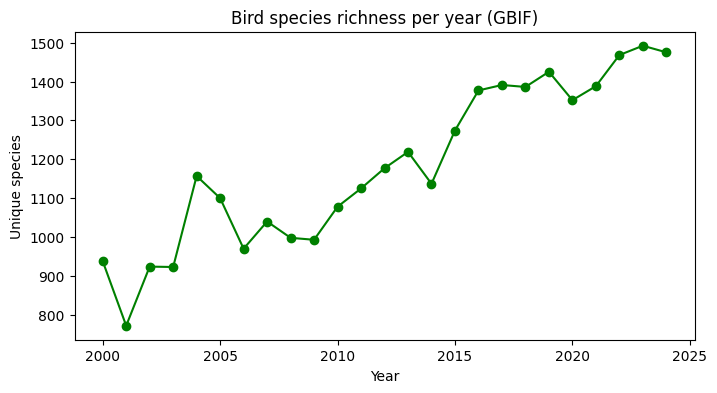

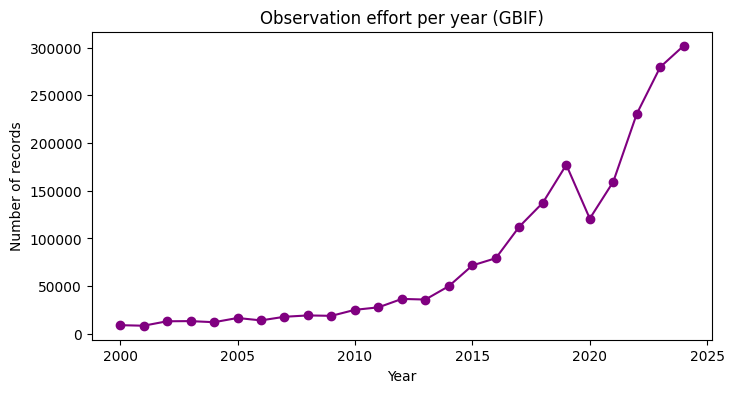

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(yearly["year"], yearly["species_richness"], marker="o", color = 'green')
plt.title("Bird species richness per year (GBIF)")
plt.xlabel("Year")
plt.ylabel("Unique species")
plt.show()

plt.figure(figsize=(8,4))
plt.plot(yearly["year"], yearly["obs_count"], marker="o", color = 'purple')
plt.title("Observation effort per year (GBIF)")
plt.xlabel("Year")
plt.ylabel("Number of records")
plt.savefig("figures/obs_effort.png")
plt.show()

# GFW API Data Acquisition

Annual forest loss (in hectares) for the Amazon Basin is obtained using the 
**Global Forest Watch (GFW) Data API**.

1. Load the Amazon Basin polygon from a GeoJSON (map.geojson) file.  
2. Loop through each year (2001–2024).  
3. Submit a SQL query to the GFW API requesting `SUM(area__ha)` for that year.  
4. Store results in a clean dataframe ("forest_loss_amazon.csv").  
5. Verify status and handle possible API errors.

This produces a complete time-series dataset aligned with the GBIF (bird richness) data.

In [98]:
import os

API_KEY = os.environ.get("GFW_API_KEY")
if API_KEY is None:
    raise ValueError("Please set the GFW_API_KEY environment variable.")


# load Amazon Basin polygon
shapes_dir = Path("data") / "shapes"
geojson_path = shapes_dir / "map.geojson"

with open(geojson_path) as f:
    geo = json.load(f)

if geo.get("type") == "FeatureCollection":
    geometry = geo["features"][0]["geometry"]
else:
    geometry = geo["geometry"]

# for the years
years = list(range(2001, 2025))   # 2001–2024 inclusive

# API endpoint (JSON)
url = "https://data-api.globalforestwatch.org/dataset/umd_tree_cover_loss/v1.9/query/json"

headers = {"x-api-key": API_KEY, "Content-Type": "application/json"}

rows = []

for y in years:
    sql = f"""
    SELECT
      SUM(area__ha) AS loss_ha
    FROM results
    WHERE umd_tree_cover_loss__year = {y}
    """

    payload = {"sql": sql, "geometry": geometry}

    resp = requests.post(url, headers=headers, json=payload)
    print("year", y, "status", resp.status_code)

    data = resp.json()
    if data.get("status") != "success":
        print("ERROR:", data)
        continue

    loss_val = data["data"][0].get("loss_ha", 0)
    rows.append({"year": y, "loss_ha": loss_val})

# build dataframe and save as csv file
forest = pd.DataFrame(rows).sort_values("year")
print(forest)

forest_path = data_dir / "forest_loss_amazon.csv"
forest.to_csv(forest_path, index=False)
print()
print("Saved forest_loss_amazon.csv with shape:", forest.shape)

year 2001 status 200
year 2002 status 200
year 2003 status 200
year 2004 status 200
year 2005 status 200
year 2006 status 200
year 2007 status 200
year 2008 status 200
year 2009 status 200
year 2010 status 200
year 2011 status 200
year 2012 status 200
year 2013 status 200
year 2014 status 200
year 2015 status 200
year 2016 status 200
year 2017 status 200
year 2018 status 200
year 2019 status 200
year 2020 status 200
year 2021 status 200
year 2022 status 200
year 2023 status 200
year 2024 status 200
    year       loss_ha
0   2001  6.085993e+05
1   2002  7.727938e+05
2   2003  5.867543e+05
3   2004  7.813801e+05
4   2005  1.026631e+06
5   2006  7.397735e+05
6   2007  5.716241e+05
7   2008  5.657609e+05
8   2009  5.323584e+05
9   2010  5.902680e+05
10  2011  5.418459e+05
11  2012  7.114728e+05
12  2013  5.099748e+05
13  2014  7.196470e+05
14  2015  6.155768e+05
15  2016  1.671053e+06
16  2017  1.152615e+06
17  2018  9.497864e+05
18  2019  1.034820e+06
19  2020  1.057192e+06
20  2021  1.1

### Loading the Forest Loss Dataset & Running Diagnostics

In [99]:
forest = pd.read_csv(data_dir / "forest_loss_amazon.csv")

print(forest.dtypes)
print()

print(forest.isna().sum())
print()

print(forest.head())
print()

print(forest.tail())
print()

print("shape of dataset:", forest.shape)

year         int64
loss_ha    float64
dtype: object

year       0
loss_ha    0
dtype: int64

   year       loss_ha
0  2001  6.085993e+05
1  2002  7.727938e+05
2  2003  5.867543e+05
3  2004  7.813801e+05
4  2005  1.026631e+06

    year       loss_ha
19  2020  1.057192e+06
20  2021  1.120724e+06
21  2022  1.279220e+06
22  2023  8.384901e+05
23  2024  1.522110e+06

shape of dataset: (24, 2)


### Statistics of forest dataset:

In [19]:
print(forest["year"].min(), forest["year"].max())
print(forest.isna().sum())
forest.describe()

2001 2024
year       0
loss_ha    0
dtype: int64


,year,loss_ha
count,24.000000,2.400000e+01
mean,2012.500000,8.541863e+05
std,7.071068,3.211161e+05
min,2001.000000,5.099748e+05
25%,2006.750000,5.893895e+05
50%,2012.500000,7.562837e+05
75%,2018.250000,1.040413e+06
max,2024.000000,1.671053e+06


# Cleaning and Preparing GFW Data

In [20]:
forest["year"] = forest["year"].astype(int)
forest = forest[(forest["year"] >= 2001) & (forest["year"] <= 2024)]
forest = forest.sort_values("year")

In [21]:
print(forest["year"].min(), forest["year"].max())

2001 2024


### Loading the Annual Bird Richness Data

In [22]:
birds_yearly = pd.read_csv(data_dir / "bird_richness_by_year.csv")
print(birds_yearly.head())

   year  species_richness  obs_count
0  2000               938       9101
1  2001               772       8514
2  2002               924      13170
3  2003               923      13352
4  2004              1157      12192


# Merging Datasets

In [23]:
merged = birds_yearly.merge(forest, on="year", how="inner")
print(merged.shape)
print(merged.head())

merged.to_csv("amazon_birds_forest_merged.csv", index=False)

(24, 4)
   year  species_richness  obs_count       loss_ha
0  2001               772       8514  6.085993e+05
1  2002               924      13170  7.727938e+05
2  2003               923      13352  5.867543e+05
3  2004              1157      12192  7.813801e+05
4  2005              1100      16622  1.026631e+06


In [24]:
merged.describe() #summary statistics

,year,species_richness,obs_count,loss_ha
count,24.000000,24.00000,24.000000,2.400000e+01
mean,2012.500000,1193.37500,82477.958333,8.541863e+05
std,7.071068,206.84731,88976.406412,3.211161e+05
min,2001.000000,772.00000,8514.000000,5.099748e+05
25%,2006.750000,1029.50000,17576.000000,5.893895e+05
50%,2012.500000,1167.00000,36272.000000,7.562837e+05
75%,2018.250000,1386.50000,124930.750000,1.040413e+06
max,2024.000000,1492.00000,301932.000000,1.671053e+06


In [100]:
print("min:", merged["year"].min(), "max:", merged["year"].max())
print(merged.isna().sum())

min: 2001 max: 2024
year                0
species_richness    0
obs_count           0
loss_ha             0
loss_lag0           0
loss_lag1           1
loss_lag2           2
loss_lag3           3
loss_lag4           4
loss_lag5           5
loss_bin            1
dtype: int64


---

# Q1: Forest Cover Change & Correlation with Bird Diversity

## Visualizations of Merged Data

### Time-series plots

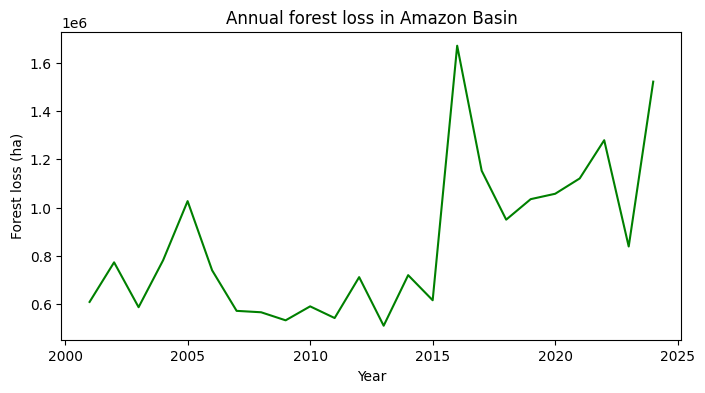

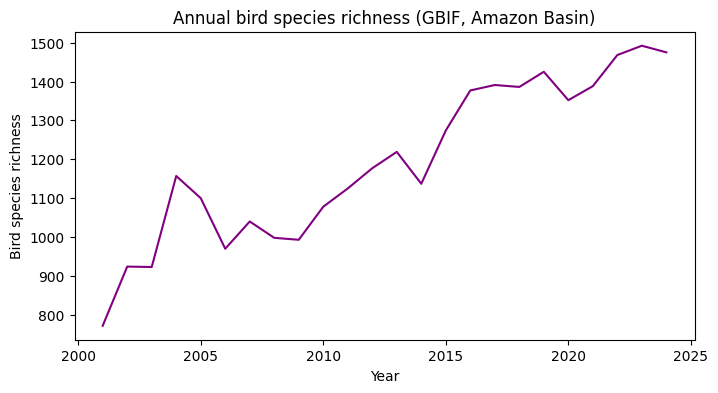

In [27]:
plt.figure(figsize=(8,4))
plt.plot(merged["year"], merged["loss_ha"], color = 'green')
plt.ylabel("Forest loss (ha)")
plt.xlabel("Year")
plt.title("Annual forest loss in Amazon Basin")
plt.savefig("figures/forest_loss_timeseries.png")
plt.show()

plt.figure(figsize=(8,4))
plt.plot(merged["year"], merged["species_richness"], color = 'purple')
plt.ylabel("Bird species richness")
plt.xlabel("Year")
plt.title("Annual bird species richness (GBIF, Amazon Basin)")
plt.savefig("figures/bird_richness_timeseries.png")
plt.show()

### Scatter Plot: Forest Loss vs. Bird Richness

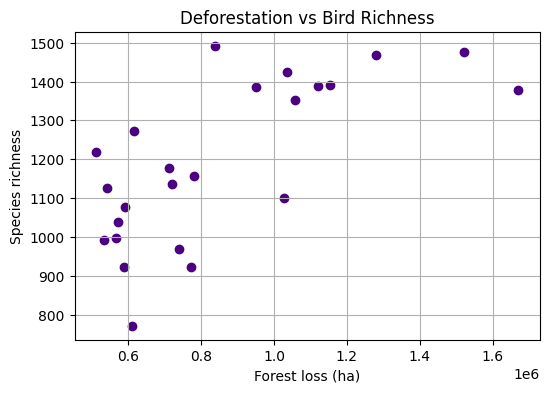

In [28]:
plt.figure(figsize=(6,4))
plt.scatter(merged["loss_ha"], merged["species_richness"], color = 'indigo')
plt.xlabel("Forest loss (ha)")
plt.ylabel("Species richness")
plt.title("Deforestation vs Bird Richness")
plt.grid(True)
plt.savefig("figures/forestloss_vs_richness.png")
plt.show()

## Linear Regression Modeling

In [82]:
from sklearn.linear_model import LinearRegression
import numpy as np

X = merged["loss_ha"].values.reshape(-1, 1)
y = merged["species_richness"].values

model = LinearRegression()
model.fit(X, y)

print("Slope:", model.coef_[0])
print("Intercept:", model.intercept_)
print("R²:", model.score(X, y))

Slope: 0.00044741311247510846
Intercept: 811.2008520341236
R²: 0.482438275213834


## Correlation b/w Annual Forest Loss and Bird Richness
Computing a Pearson correlation matrix to assess their linear relationship without accounting for delays

In [29]:
merged[["species_richness", "loss_ha"]].corr()

,species_richness,loss_ha
species_richness,1.000000,0.694578
loss_ha,0.694578,1.000000


#### Interpretation:

Pearson correlation: 0.695
- This positive correlation suggests richness increases with forest loss, but this is likely because of sampling bias (see Question 5).
- As birding activity increased over time, both observations **and** forest loss increased.

## Lag Analyses: One year & Multi year

### One year:

In [31]:
merged["loss_lag1"] = merged["loss_ha"].shift(1)
merged[["species_richness", "loss_lag1"]].corr()

,species_richness,loss_lag1
species_richness,1.000000,0.595858
loss_lag1,0.595858,1.000000


### Multi year:

In [32]:
for lag in range(1, 6):
    merged[f"loss_lag{lag}"] = merged["loss_ha"].shift(lag)
    corr = merged[["species_richness", f"loss_lag{lag}"]].corr().iloc[0,1]
    print(f"Lag {lag}: {corr}")

Lag 1: 0.5958583953206602
Lag 2: 0.5797333210702383
Lag 3: 0.4776402816817376
Lag 4: 0.30239375130072904
Lag 5: 0.3234873701240349


---

# Q2: Endemic vs Generalist Species Trends

### Trait Assignment based on Geographic Range

In [101]:
from pathlib import Path
import pandas as pd
import numpy as np

data_dir = Path("data")

df["species_clean"] = df["species"].astype(str).str.strip().str.lower()

# Assign guild based on geographic range (number of countries observed in)
country_range = df.groupby('species_clean')['countryCode'].nunique().reset_index()
country_range.columns = ['species_clean', 'num_countries']

# Species found in 1-2 countries = endemic/specialist
# Species found in 3+ countries = generalist (wide-ranging)
def assign_guild(num_countries):
    if num_countries <= 2:
        return "endemic"
    else:
        return "generalist"

country_range['guild'] = country_range['num_countries'].apply(assign_guild)

traits_df = country_range[['species_clean', 'guild']]

traits_path = data_dir / "bird_traits_amazon.csv"
traits_df.to_csv(traits_path, index=False)

print("Created traits file based on geographic range:", traits_path)
print("\nGuild distribution:")
print(traits_df['guild'].value_counts())
print("\nExample species:")
print(traits_df.head(10))

Created traits file based on geographic range: data/bird_traits_amazon.csv

Guild distribution:
guild
generalist    1064
endemic        753
Name: count, dtype: int64

Example species:
             species_clean       guild
0           aburria aburri  generalist
1        accipiter bicolor  generalist
2       accipiter collaris     endemic
3          accipiter nisus     endemic
4    accipiter poliogaster  generalist
5       accipiter striatus  generalist
6  accipiter superciliosus  generalist
7     acropternis orthonyx     endemic
8       actitis macularius  generalist
9    adelomyia melanogenys  generalist


### Merge data & filter by guild

In [37]:
traits = pd.read_csv(traits_path)
df_traits = df.merge(traits, on="species_clean", how="left")
df_traits = df_traits.dropna(subset=["guild"])

### Calculate Annual Richness

In [102]:
endemic = df_traits[df_traits["guild"] == "endemic"]
generalist = df_traits[df_traits["guild"] == "generalist"]

endemic_yearly = ( endemic.groupby("year")["species_clean"].nunique().reset_index(name="endemic_richness"))

generalist_yearly = (generalist.groupby("year")["species_clean"].nunique().reset_index(name="generalist_richness"))

richness_traits_yearly = (endemic_yearly.merge(generalist_yearly, on="year", how="outer").sort_values("year"))

### Visualize a time-series plot

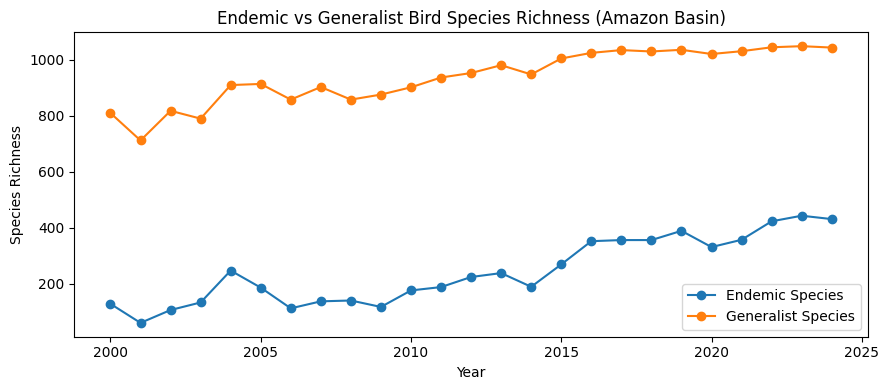

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 4))
plt.plot(richness_traits_yearly["year"],
         richness_traits_yearly["endemic_richness"],
         marker="o", label="Endemic Species")

plt.plot(richness_traits_yearly["year"],
         richness_traits_yearly["generalist_richness"],
         marker="o", label="Generalist Species")

plt.xlabel("Year")
plt.ylabel("Species Richness")
plt.title("Endemic vs Generalist Bird Species Richness (Amazon Basin)")
plt.legend()
plt.tight_layout()

fig_dir = Path("figures")
fig_dir.mkdir(exist_ok=True)
plt.savefig(fig_dir / "Q2_endemic_vs_generalist_timeseries.png")
plt.show()


### Calculating year to year changes

In [103]:
richness_traits_yearly = richness_traits_yearly.sort_values("year")

richness_traits_yearly["endemic_change"] = (richness_traits_yearly["endemic_richness"].diff())

richness_traits_yearly["generalist_change"] = (richness_traits_yearly["generalist_richness"].diff())

changes = richness_traits_yearly.dropna(subset=["endemic_change", "generalist_change"])

#### Visualize the changes:

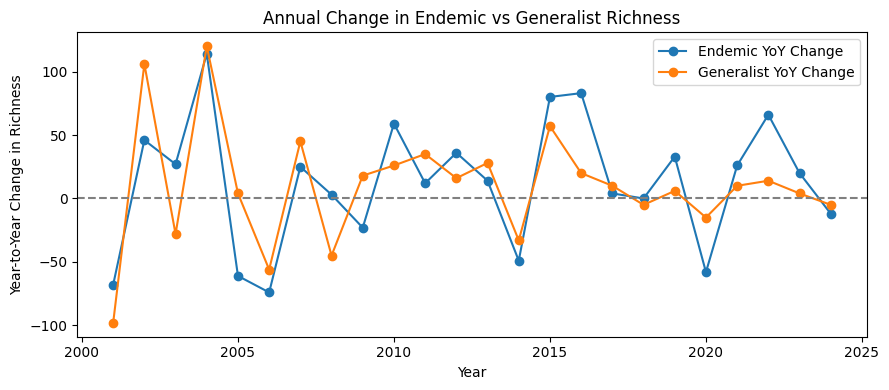

In [41]:
plt.figure(figsize=(9, 4))
plt.plot(changes["year"], changes["endemic_change"],
         marker="o", label="Endemic YoY Change")

plt.plot(changes["year"], changes["generalist_change"],
         marker="o", label="Generalist YoY Change")

plt.axhline(0, color="gray", linestyle="--")
plt.xlabel("Year")
plt.ylabel("Year-to-Year Change in Richness")
plt.title("Annual Change in Endemic vs Generalist Richness")
plt.legend()
plt.tight_layout()

plt.savefig(fig_dir / "Q2_endemic_vs_generalist_change.png")
plt.show()

### Performing a t-test:

In [105]:
from scipy.stats import ttest_ind

t_stat, p_val = ttest_ind(changes["endemic_change"], changes["generalist_change"], equal_var=False)

print("t-statistic:", t_stat)
print("p-value:", p_val)

print("\nINTERPRETATION")
if p_val > 0.05:
    print(f"No significant difference between endemic and generalist trends (p={p_val:.4f})")
    print("Both groups show similar year-to-year changes in richness.")
else:
    print(f"Significant difference detected (p={p_val:.4f})")
    if changes["endemic_change"].mean() < changes["generalist_change"].mean():
        print("Endemic species show sharper declines than generalists.")
    else:
        print("Generalist species show sharper declines than endemics.")

print(f"\nMean annual change - Endemic: {changes['endemic_change'].mean():.2f}")
print(f"Mean annual change - Generalist: {changes['generalist_change'].mean():.2f}")

t-statistic: 0.20599584871275933
p-value: 0.837708404248888

INTERPRETATION
No significant difference between endemic and generalist trends (p=0.8377)
Both groups show similar year-to-year changes in richness.

Mean annual change - Endemic: 12.62
Mean annual change - Generalist: 9.75


---

# Q3: Time Lag Analysis - Does Bird Diversity Change After Forest Loss?

In [106]:
from pathlib import Path
import pandas as pd

data_dir = Path("data")

merged_path = data_dir / "amazon_birds_forest_merged.csv"
merged = pd.read_csv(merged_path)

print(merged.head())
print(merged.columns)

   year  species_richness  obs_count       loss_ha
0  2001               772       8514  6.085993e+05
1  2002               924      13170  7.727938e+05
2  2003               923      13352  5.867543e+05
3  2004              1157      12192  7.813801e+05
4  2005              1100      16622  1.026631e+06
Index(['year', 'species_richness', 'obs_count', 'loss_ha'], dtype='object')


### Creating lagged forest loss variables:

In [112]:
max_lag = 5

# lag 0 is just the current year's forest loss
merged["loss_lag0"] = merged["loss_ha"]

for lag in range(1, max_lag + 1):
    merged[f"loss_lag{lag}"] = merged["loss_ha"].shift(lag)

merged.head()

,year,species_richness,obs_count,loss_ha,loss_lag0,loss_lag1,loss_lag2,loss_lag3,loss_lag4,loss_lag5
0,2001,772,8514,6.085993e+05,6.085993e+05,NaN,NaN,NaN,NaN,NaN
1,2002,924,13170,7.727938e+05,7.727938e+05,608599.26276,NaN,NaN,NaN,NaN
2,2003,923,13352,5.867543e+05,5.867543e+05,772793.84562,608599.26276,NaN,NaN,NaN
3,2004,1157,12192,7.813801e+05,7.813801e+05,586754.28895,772793.84562,608599.26276,NaN,NaN
4,2005,1100,16622,1.026631e+06,1.026631e+06,781380.13729,586754.28895,772793.84562,608599.26276,NaN


### Correlation for each lag period:

In [113]:
import numpy as np

corr_rows = []

for lag in range(0, max_lag + 1):
    col = f"loss_lag{lag}"
    sub = merged[["species_richness", col]].dropna()
    r = sub["species_richness"].corr(sub[col])
    corr_rows.append({"lag_years": lag, "corr": r})

lag_corr = pd.DataFrame(corr_rows)
print(lag_corr)

   lag_years      corr
0          0  0.694578
1          1  0.595858
2          2  0.579733
3          3  0.477640
4          4  0.302394
5          5  0.323487


### Visualize lag correlation pattern:

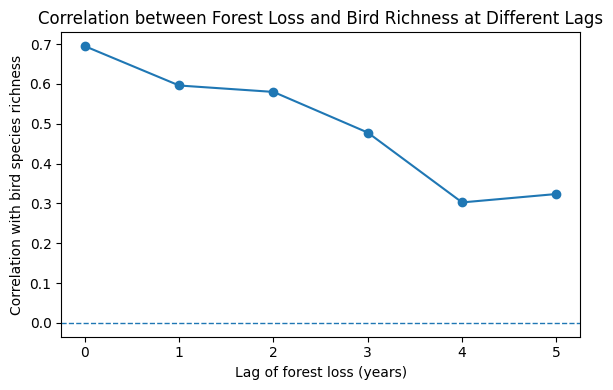

In [114]:
import matplotlib.pyplot as plt
from pathlib import Path

fig_dir = Path("figures")
fig_dir.mkdir(exist_ok=True)

plt.figure(figsize=(6, 4))
plt.plot(lag_corr["lag_years"], lag_corr["corr"], marker="o")
plt.axhline(0, linestyle="--", linewidth=1)
plt.xticks(lag_corr["lag_years"])
plt.xlabel("Lag of forest loss (years)")
plt.ylabel("Correlation with bird species richness")
plt.title("Correlation between Forest Loss and Bird Richness at Different Lags")
plt.tight_layout()

plt.savefig(fig_dir / "Q3_lag_correlation_curve.png")
plt.show()

### Multi lag regression analysis

In [115]:
from sklearn.linear_model import LinearRegression

# Choose which lags to include as predictors
lags_to_use = list(range(0, max_lag + 1))   # 0–5 year lags

lag_cols = [f"loss_lag{lag}" for lag in lags_to_use]

reg_data = merged.dropna(subset=["species_richness"] + lag_cols)

X = reg_data[lag_cols].values
y = reg_data["species_richness"].values

lag_model = LinearRegression()
lag_model.fit(X, y)

print("R^2 (multi-lag regression):", lag_model.score(X, y))

for lag, coef in zip(lags_to_use, lag_model.coef_):
    print(f"Coefficient for loss_lag{lag}: {coef}")

R^2 (multi-lag regression): 0.715622378279329
Coefficient for loss_lag0: 0.0002825415653432785
Coefficient for loss_lag1: 0.00015923592496816372
Coefficient for loss_lag2: 6.159133311804773e-05
Coefficient for loss_lag3: 0.00011200522691841405
Coefficient for loss_lag4: -6.286628669180188e-05
Coefficient for loss_lag5: 4.241060278485933e-05


#### Interpretation:

Multi-lag regression R²: 0.716

The highest positive coefficients indicate which lag periods have
the strongest association with current bird richness.

Note: Positive coefficients suggest sampling bias dominates over
ecological effects. True ecological impacts would show negative coefficients.

### Identify & Visualize best correlated lag 

Best lag (by |corr|): 0


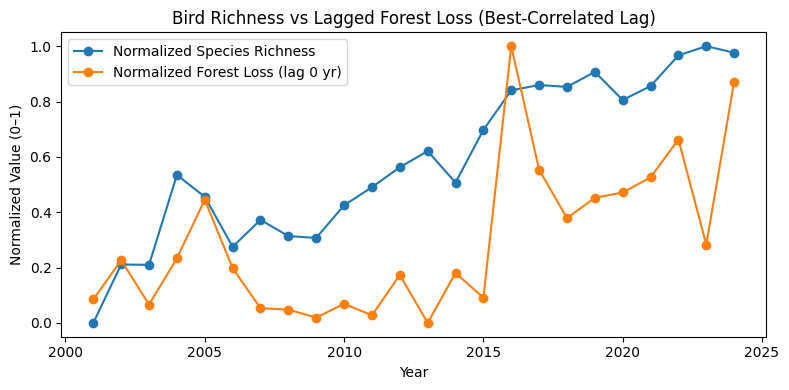

In [116]:
# Find lag with strongest absolute correlation
best_row = lag_corr.iloc[lag_corr["corr"].abs().idxmax()]
best_lag = int(best_row["lag_years"])
print("Best lag (by |corr|):", best_lag)

# Build a scaled version of the chosen lag series
plot_df = merged[["year", "species_richness", f"loss_lag{best_lag}"]].dropna()

# Normalize both series to 0–1
plot_df = plot_df.sort_values("year").copy()
plot_df["richness_norm"] = (
    (plot_df["species_richness"] - plot_df["species_richness"].min())
    / (plot_df["species_richness"].max() - plot_df["species_richness"].min())
)
plot_df["loss_norm"] = (
    (plot_df[f"loss_lag{best_lag}"] - plot_df[f"loss_lag{best_lag}"].min())
    / (plot_df[f"loss_lag{best_lag}"].max() - plot_df[f"loss_lag{best_lag}"].min())
)

plt.figure(figsize=(8, 4))
plt.plot(plot_df["year"], plot_df["richness_norm"], marker="o", label="Normalized Species Richness")
plt.plot(plot_df["year"], plot_df["loss_norm"], marker="o", label=f"Normalized Forest Loss (lag {best_lag} yr)")
plt.xlabel("Year")
plt.ylabel("Normalized Value (0–1)")
plt.title("Bird Richness vs Lagged Forest Loss (Best-Correlated Lag)")
plt.legend()
plt.tight_layout()

plt.savefig(fig_dir / "Q3_richness_vs_best_lagged_loss_timeseries.png")
plt.show()

---

# Q4: Is There a Threshold in Forest Loss Beyond Which Diversity Drops?

### Search for optimal threshold using piecewise regression:

In [118]:
import pandas as pd
import numpy as np

df_pw = merged[["species_richness", "loss_ha"]].dropna().copy()
x = df_pw["loss_ha"].values
y = df_pw["species_richness"].values

In [119]:
from sklearn.linear_model import LinearRegression

break_candidates = np.linspace(x.min(), x.max(), 50)  # 50 candidate breakpoints
errors = []

for b in break_candidates:
    # Left segment
    left_mask = x <= b
    right_mask = x > b
    
    if left_mask.sum() < 2 or right_mask.sum() < 2:
        errors.append(np.inf)
        continue
    
    # Fit left
    model_left = LinearRegression().fit(x[left_mask].reshape(-1,1), y[left_mask])
    pred_left = model_left.predict(x[left_mask].reshape(-1,1))
    
    # Fit right
    model_right = LinearRegression().fit(x[right_mask].reshape(-1,1), y[right_mask])
    pred_right = model_right.predict(x[right_mask].reshape(-1,1))
    
    # Combined SSE (sum squared error)
    sse = ((y[left_mask] - pred_left)**2).sum() + ((y[right_mask] - pred_right)**2).sum()
    errors.append(sse)

best_break = break_candidates[np.argmin(errors)]
best_break

np.float64(794320.3655726531)

### Fit final piecewise model & extract parameters

In [120]:
b = best_break

left_mask = x <= b
right_mask = x > b

model_left = LinearRegression().fit(x[left_mask].reshape(-1,1), y[left_mask])
model_right = LinearRegression().fit(x[right_mask].reshape(-1,1), y[right_mask])

print("Best threshold (forest loss):", b)
print("Left slope:", model_left.coef_[0])
print("Right slope:", model_right.coef_[0])

Best threshold (forest loss): 794320.3655726531
Left slope: -2.5681152389531607e-05
Right slope: 6.672705866534515e-05


### Validate improvement over simple linear model

In [122]:
from sklearn.metrics import mean_squared_error

# Simple linear model (no threshold)
simple_model = LinearRegression().fit(x.reshape(-1,1), y)
simple_pred = simple_model.predict(x.reshape(-1,1))
simple_mse = mean_squared_error(y, simple_pred)

# Piecewise predictions
pw_pred = np.zeros_like(y)
pw_pred[left_mask] = model_left.predict(x[left_mask].reshape(-1,1))
pw_pred[right_mask] = model_right.predict(x[right_mask].reshape(-1,1))
pw_mse = mean_squared_error(y, pw_pred)

print("\nMODEL COMPARISON")
print(f"Simple linear model MSE: {simple_mse:.2f}")
print(f"Piecewise model MSE: {pw_mse:.2f}")
print(f"Improvement: {((simple_mse - pw_mse)/simple_mse * 100):.1f}%")

print("\nINTERPRETATION")
print(f"Optimal threshold: {b:.0f} hectares of forest loss")
print(f"Below threshold - slope: {model_left.coef_[0]:.6f}")
print(f"Above threshold - slope: {model_right.coef_[0]:.6f}")

if abs(model_right.coef_[0]) > abs(model_left.coef_[0]):
    print("\nThe steeper slope above the threshold suggests an accelerating")
    print("relationship between forest loss and observed richness at high loss levels.")
else:
    print("\nThe relationship is relatively consistent across forest loss levels.")


MODEL COMPARISON
Simple linear model MSE: 21221.62
Piecewise model MSE: 14545.54
Improvement: 31.5%

INTERPRETATION
Optimal threshold: 794320 hectares of forest loss
Below threshold - slope: -0.000026
Above threshold - slope: 0.000067

The steeper slope above the threshold suggests an accelerating
relationship between forest loss and observed richness at high loss levels.


### Visualize piecewise regression with threshold

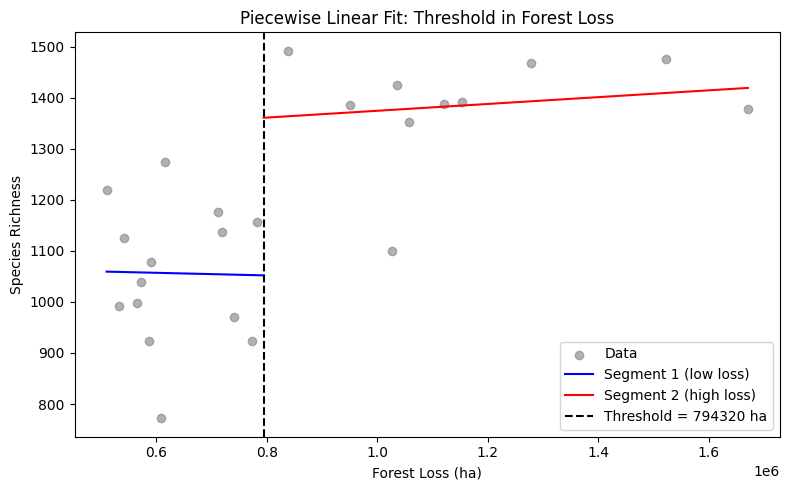

In [123]:
import matplotlib.pyplot as plt
from pathlib import Path

fig_dir = Path("figures")
fig_dir.mkdir(exist_ok=True)

plt.figure(figsize=(8,5))
plt.scatter(x, y, color="gray", alpha=0.6, label="Data")

# left segment
xx_left = np.linspace(x.min(), b, 100)
yy_left = model_left.predict(xx_left.reshape(-1,1))
plt.plot(xx_left, yy_left, color="blue", label="Segment 1 (low loss)")

# right segment
xx_right = np.linspace(b, x.max(), 100)
yy_right = model_right.predict(xx_right.reshape(-1,1))
plt.plot(xx_right, yy_right, color="red", label="Segment 2 (high loss)")

plt.axvline(b, color="black", linestyle="--", label=f"Threshold = {b:.0f} ha")
plt.xlabel("Forest Loss (ha)")
plt.ylabel("Species Richness")
plt.title("Piecewise Linear Fit: Threshold in Forest Loss")
plt.legend()
plt.tight_layout()

plt.savefig(fig_dir / "Q4_piecewise_threshold.png")
plt.show()

### Forest loss bins

In [124]:
bins = np.linspace(merged["loss_ha"].min(), merged["loss_ha"].max(), 6)  # 5 bins

merged["loss_bin"] = pd.cut(merged["loss_ha"], bins=bins)

### Average richness per bin

In [125]:
bin_summary = (merged.groupby("loss_bin")["species_richness"].mean().reset_index())
bin_summary

/var/folders/87/2ddmhzmx6hj6hwln8h1zcyhc0000gn/T/ipykernel_73399/2698729261.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_summary = (merged.groupby("loss_bin")["species_richness"].mean().reset_index())


,loss_bin,species_richness
0,"(509974.767, 742190.339]",1044.272727
1,"(742190.339, 974405.912]",1239.750000
2,"(974405.912, 1206621.484]",1331.200000
3,"(1206621.484, 1438837.057]",1468.000000
4,"(1438837.057, 1671052.629]",1426.000000


### Visualize binned forest loss analysis

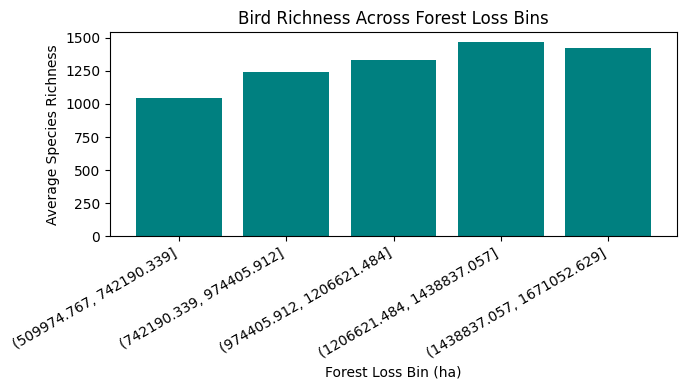

In [59]:
plt.figure(figsize=(7,4))
plt.bar(bin_summary["loss_bin"].astype(str),
        bin_summary["species_richness"],
        color="teal")

plt.xticks(rotation=30, ha="right")
plt.xlabel("Forest Loss Bin (ha)")
plt.ylabel("Average Species Richness")
plt.title("Bird Richness Across Forest Loss Bins")
plt.tight_layout()

plt.savefig(fig_dir / "Q4_binned_forest_loss.png")
plt.show()

---

# Q5: Sampling Bias in GBIF Data

### Compute Temporal Sampling Effort

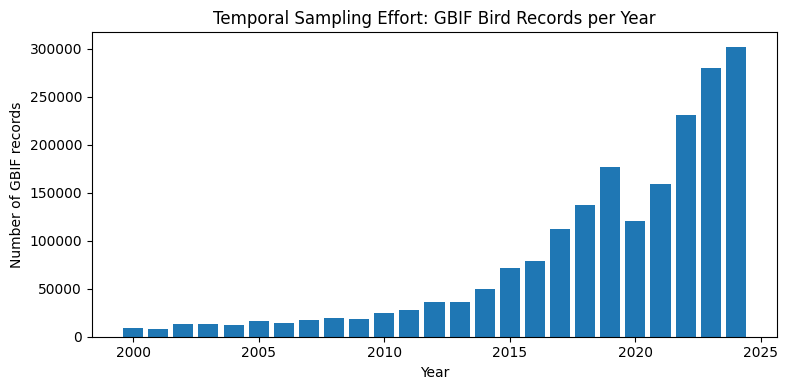

In [126]:
import matplotlib.pyplot as plt
from pathlib import Path

fig_dir = Path("figures")
fig_dir.mkdir(exist_ok=True)

obs_by_year = (df.groupby("year").size().reset_index(name="obs_count").sort_values("year"))

plt.figure(figsize=(8, 4))
plt.bar(obs_by_year["year"], obs_by_year["obs_count"])
plt.xlabel("Year")
plt.ylabel("Number of GBIF records")
plt.title("Temporal Sampling Effort: GBIF Bird Records per Year")
plt.tight_layout()
plt.savefig(fig_dir / "Q5_obs_per_year_bar.png")
plt.show()

### Spatial Sampling Density

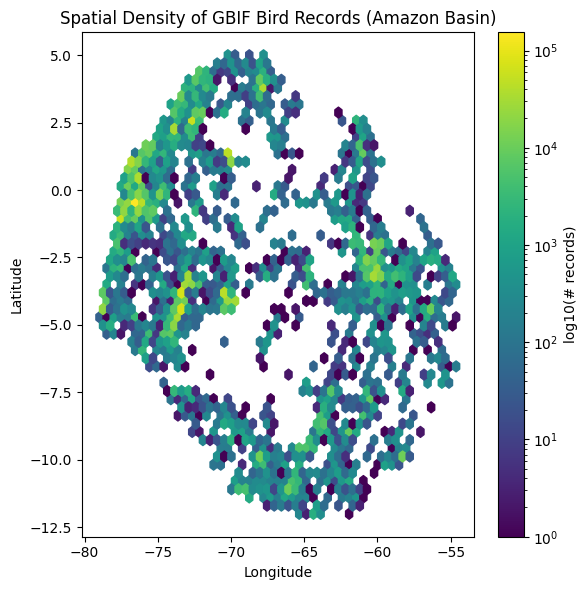

In [62]:
plt.figure(figsize=(6, 6))
hb = plt.hexbin(
    df["decimalLongitude"],
    df["decimalLatitude"],
    gridsize=50,
    bins="log"
)
plt.colorbar(hb, label="log10(# records)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial Density of GBIF Bird Records (Amazon Basin)")
plt.tight_layout()
plt.savefig(fig_dir / "Q5_hexbin_spatial_density.png")
plt.show()

### Grid Based Sampling Intensity

/var/folders/87/2ddmhzmx6hj6hwln8h1zcyhc0000gn/T/ipykernel_73399/559704443.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grid_counts = (df.groupby(["lat_bin", "lon_bin"]).size().reset_index(name="obs_count"))


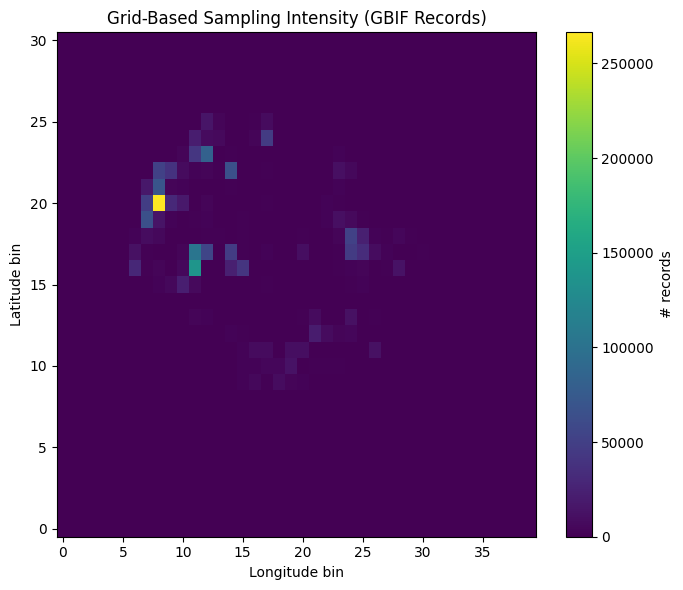

In [149]:
import numpy as np
import pandas as pd

# Define coarse spatial grid (1-degree cells)
lon_bins = np.arange(-85, -44, 1)  
lat_bins = np.arange(-21, 11, 1)

df["lon_bin"] = pd.cut(df["decimalLongitude"], bins=lon_bins)
df["lat_bin"] = pd.cut(df["decimalLatitude"], bins=lat_bins)

grid_counts = (df.groupby(["lat_bin", "lon_bin"]).size().reset_index(name="obs_count"))

grid_pivot = grid_counts.pivot(index="lat_bin", columns="lon_bin", values="obs_count")

plt.figure(figsize=(7, 6))
plt.imshow(grid_pivot.values, origin="lower", aspect="auto")
plt.colorbar(label="# records")
plt.xlabel("Longitude bin")
plt.ylabel("Latitude bin")
plt.title("Grid-Based Sampling Intensity (GBIF Records)")
plt.tight_layout()
plt.savefig(fig_dir / "Q5_grid_sampling_intensity.png")
plt.show()

### Sampling Effort by Country

  countryCode  obs_count
0          CO     615381
1          EC     496956
2          BR     447524
3          PE     384583
4          BO      39498
Index(['countryCode', 'obs_count'], dtype='object')


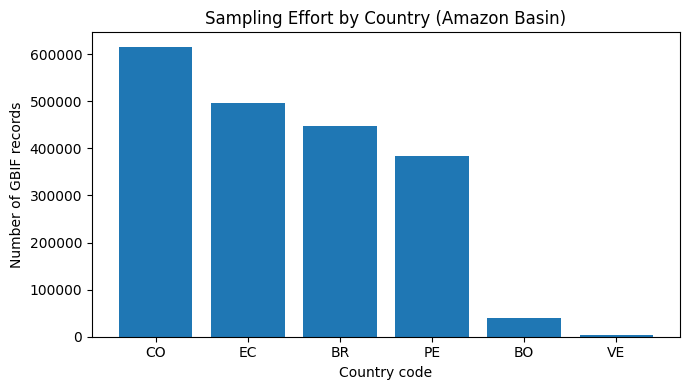

In [128]:
import matplotlib.pyplot as plt

obs_by_country = (df["countryCode"].value_counts().rename_axis("countryCode").reset_index(name="obs_count"))

print(obs_by_country.head())
print(obs_by_country.columns)  

plt.figure(figsize=(7, 4))
plt.bar(obs_by_country["countryCode"], obs_by_country["obs_count"])
plt.xlabel("Country code")
plt.ylabel("Number of GBIF records")
plt.title("Sampling Effort by Country (Amazon Basin)")
plt.tight_layout()
plt.savefig(fig_dir / "Q5_obs_per_country.png")
plt.show()

### Compute Effort Normalized Richness

In [130]:
from pathlib import Path
import pandas as pd

data_dir = Path("data")
yearly_path = data_dir / "bird_richness_by_year.csv"
yearly = pd.read_csv(yearly_path)

# Normalized richness (species per 10,000 records)
yearly["richness_per_10k_records"] = (yearly["species_richness"] / (yearly["obs_count"] / 10000.0))

yearly["obs_scaled"] = (yearly["obs_count"] - yearly["obs_count"].min()) / (yearly["obs_count"].max() - yearly["obs_count"].min())
yearly["richness_scaled"] = (yearly["species_richness"] - yearly["species_richness"].min()) / (
    yearly["species_richness"].max() - yearly["species_richness"].min())

yearly.head()

,year,species_richness,obs_count,richness_per_10k_records,obs_scaled,richness_scaled
0,2000,938,9101,1030.655972,0.002001,0.230556
1,2001,772,8514,906.741837,0.000000,0.000000
2,2002,924,13170,701.594533,0.015868,0.211111
3,2003,923,13352,691.282205,0.016488,0.209722
4,2004,1157,12192,948.982940,0.012535,0.534722


### Visualize raw vs effort normalized species richness:

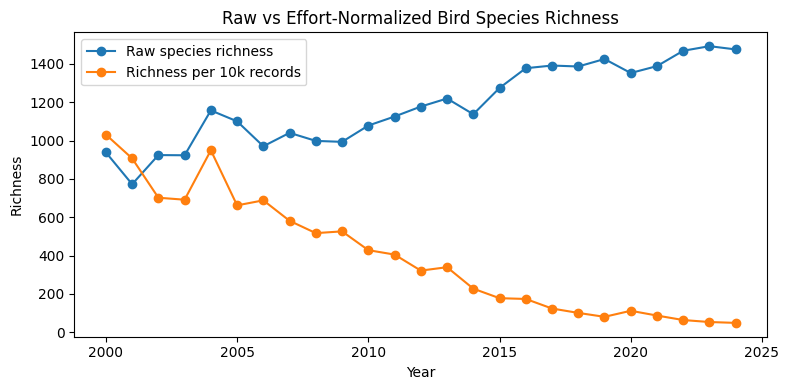

In [66]:
plt.figure(figsize=(8, 4))
plt.plot(yearly["year"], yearly["species_richness"],
         marker="o", label="Raw species richness")
plt.plot(yearly["year"], yearly["richness_per_10k_records"],
         marker="o", label="Richness per 10k records")

plt.xlabel("Year")
plt.ylabel("Richness")
plt.title("Raw vs Effort-Normalized Bird Species Richness")
plt.legend()
plt.tight_layout()
plt.savefig(fig_dir / "Q5_raw_vs_normalized_richness.png")
plt.show()

### Merge richness with forest loss & compute correlation:

In [136]:
forest = pd.read_csv(data_dir / "forest_loss_amazon.csv")
merged_norm = yearly.merge(forest, on="year", how="inner")

corr_raw = merged_norm["species_richness"].corr(merged_norm["loss_ha"])
corr_norm = merged_norm["richness_per_10k_records"].corr(merged_norm["loss_ha"])

print("Correlation (raw richness vs forest loss):", corr_raw)
print("Correlation (normalized richness vs forest loss):", corr_norm)

print("\nSAMPLING BIAS IMPACT:")
print(f"Raw correlation (richness vs loss): {corr_raw:.3f}")
print(f"Effort-normalized correlation: {corr_norm:.3f}")
print(f"\nCorrelation change: {corr_raw:.3f} → {corr_norm:.3f}")
print(f"Sign reversal: {'Yes - sampling bias reversed the relationship' if (corr_raw > 0 and corr_norm < 0) else 'No'}")

if corr_raw > 0 and corr_norm < 0:
    print("\nThis reversal demonstrates that sampling effort drives the positive")
    print("relationship seen in raw data, masking potential negative ecological effects.")
    print("After controlling for effort, we see the expected negative trend.")

Correlation (raw richness vs forest loss): 0.6945777675781408
Correlation (normalized richness vs forest loss): -0.5442084733804119

SAMPLING BIAS IMPACT:
Raw correlation (richness vs loss): 0.695
Effort-normalized correlation: -0.544

Correlation change: 0.695 → -0.544
Sign reversal: Yes - sampling bias reversed the relationship

This reversal demonstrates that sampling effort drives the positive
relationship seen in raw data, masking potential negative ecological effects.
After controlling for effort, we see the expected negative trend.


---

# Q6: Regional Differences in Bird Diversity Trends

In [137]:
import pandas as pd
import numpy as np

df["species_clean"] = df["species"].astype(str).str.strip().str.lower()

def assign_region(lon):
    if lon <= -70:
        return "West Amazon"
    elif lon <= -60:
        return "Central Amazon"
    else:
        return "East Amazon"

df["region"] = df["decimalLongitude"].apply(assign_region)

print(df["region"].value_counts())

region
West Amazon       1414127
Central Amazon     449257
East Amazon        125188
Name: count, dtype: int64


### Compute richness & sampling effort

In [139]:
regional_yearly = (df.groupby(["year", "region"]).agg(species_richness=("species_clean", "nunique"), obs_count=("species_clean", "size"))
    .reset_index()
    .sort_values(["region", "year"]))

regional_yearly.head()

,year,region,species_richness,obs_count
0,2000,Central Amazon,396,1104
3,2001,Central Amazon,472,1219
6,2002,Central Amazon,614,2545
9,2003,Central Amazon,697,3732
12,2004,Central Amazon,556,1805


### Time series of richness by region:

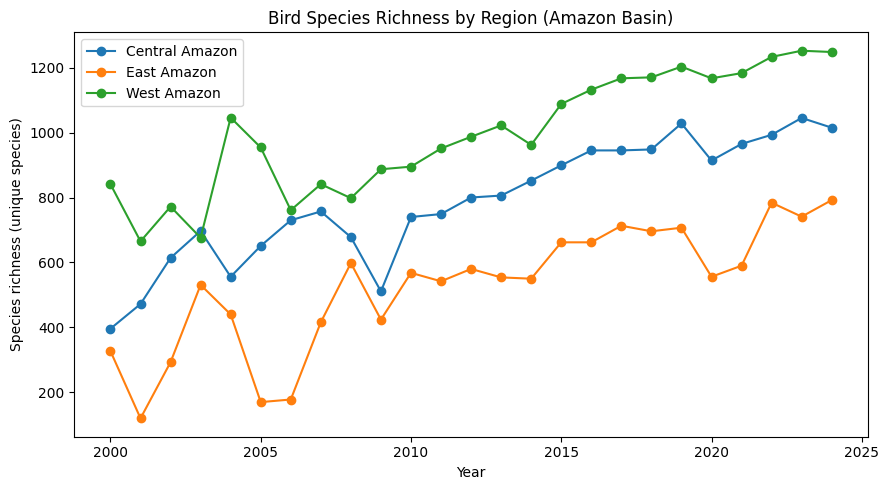

In [140]:
import matplotlib.pyplot as plt
from pathlib import Path

fig_dir = Path("figures")
fig_dir.mkdir(exist_ok=True)

plt.figure(figsize=(9, 5))

for region_name, sub in regional_yearly.groupby("region"):
    sub_sorted = sub.sort_values("year")
    plt.plot(sub_sorted["year"], sub_sorted["species_richness"], marker="o", label=region_name)

plt.xlabel("Year")
plt.ylabel("Species richness (unique species)")
plt.title("Bird Species Richness by Region (Amazon Basin)")
plt.legend()
plt.tight_layout()
plt.savefig(fig_dir / "Q6_regional_richness_timeseries.png")
plt.show()

### Fit linear models to regional richness trends

In [141]:
from sklearn.linear_model import LinearRegression

region_trends = []

for region_name, sub in regional_yearly.groupby("region"):
    sub_sorted = sub.sort_values("year")
    X = sub_sorted["year"].values.reshape(-1, 1)
    y = sub_sorted["species_richness"].values
    
    model = LinearRegression()
    model.fit(X, y)
    
    slope = model.coef_[0]
    intercept = model.intercept_
    r2 = model.score(X, y)
    
    region_trends.append({"region": region_name, "slope_richness_per_year": slope, "intercept": intercept, "r2": r2})

region_trends_df = pd.DataFrame(region_trends)
region_trends_df

,region,slope_richness_per_year,intercept,r2
0,Central Amazon,23.228462,-45947.424615,0.857663
1,East Amazon,21.598462,-42928.344615,0.697014
2,West Amazon,22.656154,-44588.141538,0.820126


### Visualization:

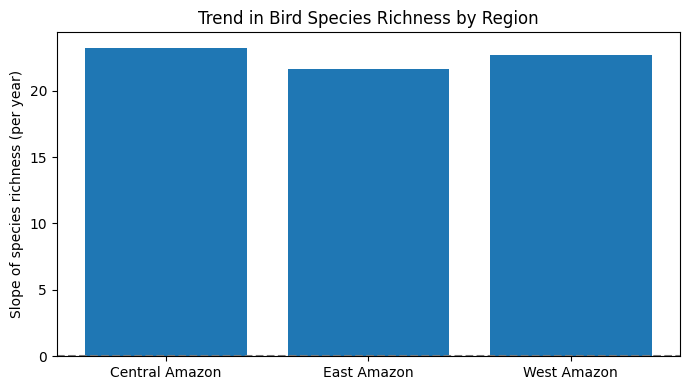

In [73]:
plt.figure(figsize=(7, 4))
plt.bar(region_trends_df["region"], region_trends_df["slope_richness_per_year"])
plt.axhline(0, color="gray", linestyle="--")
plt.ylabel("Slope of species richness (per year)")
plt.title("Trend in Bird Species Richness by Region")
plt.tight_layout()
plt.savefig(fig_dir / "Q6_regional_trend_slopes.png")
plt.show()

In [147]:
print("REGIONAL TRENDS INTERPRETATION:")
for i, row in region_trends_df.iterrows():
    print(f"\n{row['region']}:")
    print(f"  Slope: {row['slope_richness_per_year']:.2f} species/year")
    print(f"  R²: {row['r2']:.3f}")
    print(f"  Trend: {'Increasing' if row['slope_richness_per_year'] > 0 else 'Decreasing'} richness over time")

REGIONAL TRENDS INTERPRETATION:

Central Amazon:
  Slope: 23.23 species/year
  R²: 0.858
  Trend: Increasing richness over time

East Amazon:
  Slope: 21.60 species/year
  R²: 0.697
  Trend: Increasing richness over time

West Amazon:
  Slope: 22.66 species/year
  R²: 0.820
  Trend: Increasing richness over time


Note: All regions show positive slopes, consistent with increasing sampling effort rather than true ecological improvement.
Regional differences likely reflect variation in birding activity growth.